# Toy example using GNAR

SEOYEON CHOI  
2023-07-08

# Import

In [1]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import itstgcn_gb as itstgcn
import random

def save_data(data_dict,fname):
    with open(fname,'wb') as outfile:
        pickle.dump(data_dict,outfile)

def load_data(fname):
    with open(fname, 'rb') as outfile:
        data_dict = pickle.load(outfile)
    return data_dict

def toy_analyze(FX,edges,lags,train_ratio,mrate,filters,epoch,mtype): 
    data_dict = {'edges':edges, 'node_ids':{i:'node'+str(i) for i in range(FX.shape[-1])}, 'FX':FX}
    save_data(data_dict,'toy_ex_dataset.pkl')
    data_dict = load_data('toy_ex_dataset.pkl')
    loader = itstgcn.DatasetLoader(data_dict)
    dataset = loader.get_dataset(lags=lags)
    train_dataset, test_dataset = itstgcn.temporal_signal_split(dataset, train_ratio=train_ratio)
    mindex_rand = itstgcn.rand_mindex(train_dataset,mrate=mrate)
    train_dataset_miss_rand = itstgcn.miss(train_dataset,mindex_rand,mtype=mtype)
    train_dataset_padded_rand = itstgcn.padding(train_dataset_miss_rand) # padding(train_dataset_miss,method='linear'와 같음)
    lrnr_classic = itstgcn.StgcnLearner(train_dataset_padded_rand)
    lrnr_proposed = itstgcn.ITStgcnLearner(train_dataset_padded_rand)
    lrnr_classic.learn(filters=filters,epoch=epoch)
    lrnr_proposed.learn(filters=filters,epoch=epoch)
    yhat_classic=lrnr_classic(dataset)['yhat']
    yhat_proposed=lrnr_proposed(dataset)['yhat']    
    return yhat_classic,yhat_proposed

# Data

In [112]:
T = 50
t = np.linspace(0,np.pi*2,T)
e = np.random.randn(T)*0.1
y1 = np.cos(2*t)
y2 = np.cos(3*t)
y3 = y1+y2+e
y = np.stack([y1,y2,y3],axis=1)
_, N = y.shape 
train_ratio = 0.9
test_len = int(T*(1-train_ratio))
tr_len = T - test_len
test_index = [False]*tr_len + [True]*test_len 
edges = [[0,2],[1,2]]
lags = 8
mrate = 0.8
filters = 2
epoch = 50
mtype = 'rand' 
### 
yhat_classic,yhat_proposed = toy_analyze(y,edges,lags,train_ratio,mrate,filters,epoch,mtype)

50/50

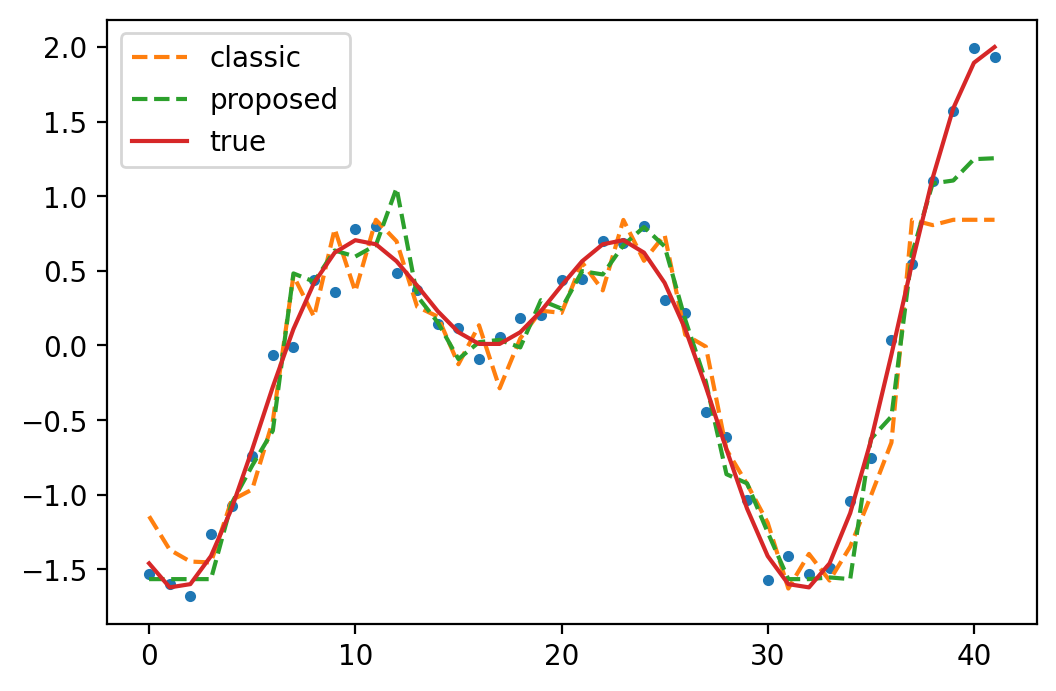

In [113]:
node = 2
plt.rcParams['figure.dpi'] = 200
plt.plot(y[lags:,node],'.')
plt.plot(yhat_classic[:,node],'--',label='classic')
plt.plot(yhat_proposed[:,node],'--',label='proposed')
plt.plot(y[lags:,0]+y[lags:,1],'-',label='true')
plt.legend()